The 3 datasets usedhere are from 10x Genomics, Fang et al. 2019 and Cusanovich et al. 2018.
It corresponds to mouse brain.

# Load Libraries

In [5]:
import anndata as ad
import scanpy as sc
import copy
import episcanpy.api as epi
import gzip
import numpy as np
import pandas as pd

In [6]:
sc.settings.set_figure_params(dpi=80, dpi_save=400)
# Specify path to the data
DATADIR=""

# Load 10x data

In [4]:
adata10x = ad.read(DATADIR+'10x_5kb_mtx_new_cellranger_january_16_2020.h5ad')
adata10x

AnnData object with n_obs × n_vars = 3880 × 545114 

In [5]:
# check if the data matrix is binary 
np.max(adata10x.X)

298.0

In [6]:
# make the data binary
epi.pp.binarize(adata10x)
np.max(adata10x.X)

In [9]:
# remove any potential empty features or barcodes
epi.pp.filter_cells(adata10x, min_features=1)
epi.pp.filter_features(adata10x, min_cells=1)
adata10x

AnnData object with n_obs × n_vars = 3880 × 499917 
    obs: 'nb_features'
    var: 'n_cells'

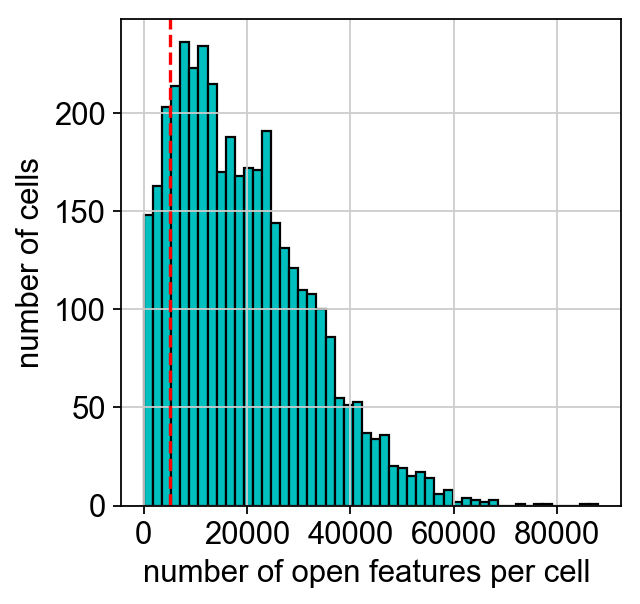

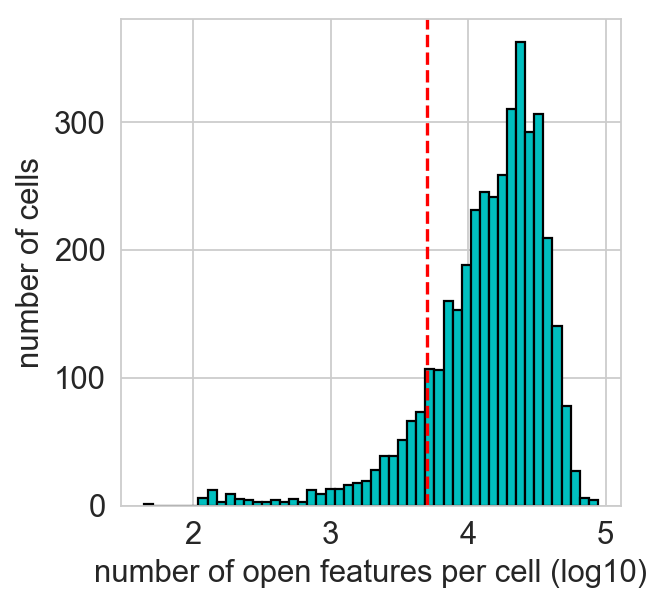

In [10]:
# set a minimum number of cells to keep 
min_features = 5000

epi.pp.coverage_cells(adata10x, binary=True, log=False, bins=50,
               threshold=min_features, save='10x_coverage_cells.png')
epi.pp.coverage_cells(adata10x, binary=True, log=10, bins=50,
               threshold=min_features, save='10x_coverage_cells.png')

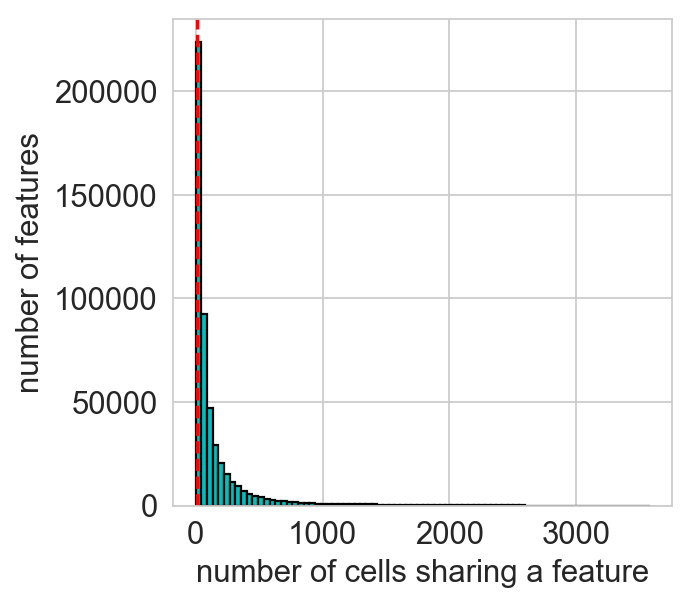

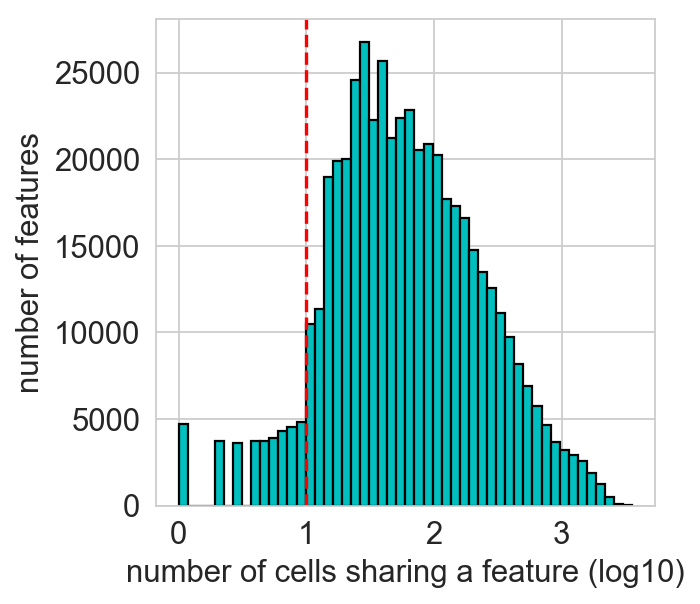

In [12]:
# minimum number of cells sharing a feature
min_cells = 10
epi.pp.coverage_features(adata10x, binary=True, log=False, 
                        threshold=min_cells)
epi.pp.coverage_features(adata10x, binary=True, log=True, 
                        threshold=min_cells)

### Actually do the filtering

In [13]:
adata10x

AnnData object with n_obs × n_vars = 3880 × 499917 
    obs: 'nb_features'
    var: 'n_cells', 'commonness'

In [14]:
min_features = 5000
epi.pp.filter_cells(adata10x, min_features=min_features)

In [15]:
adata10x

AnnData object with n_obs × n_vars = 3406 × 499917 
    obs: 'nb_features'
    var: 'n_cells', 'commonness'

In [16]:
min_cells = 10
epi.pp.filter_features(adata10x, min_cells=min_cells)

In [17]:
adata10x

AnnData object with n_obs × n_vars = 3406 × 462048 
    obs: 'nb_features'
    var: 'n_cells', 'commonness'

### Check the quality controls post filtering

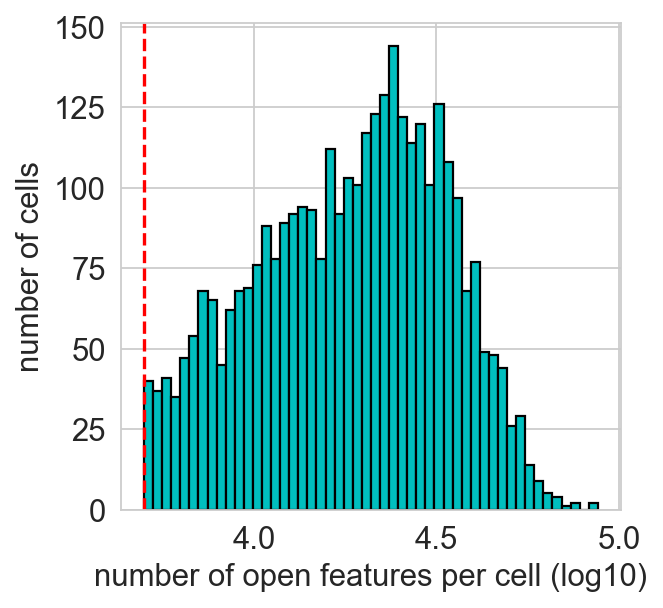

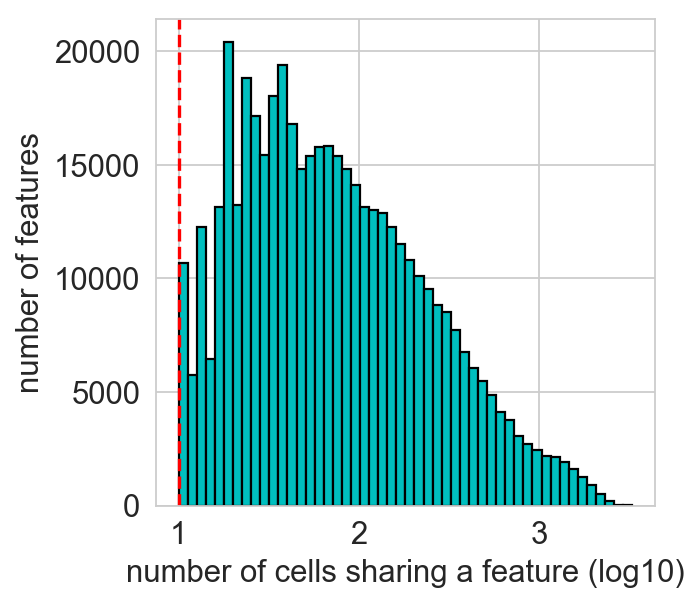

In [18]:
epi.pp.coverage_cells(adata10x, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata10x, binary=True, log='log10', bins=50, threshold=min_cells)

### Exctract most variable windows

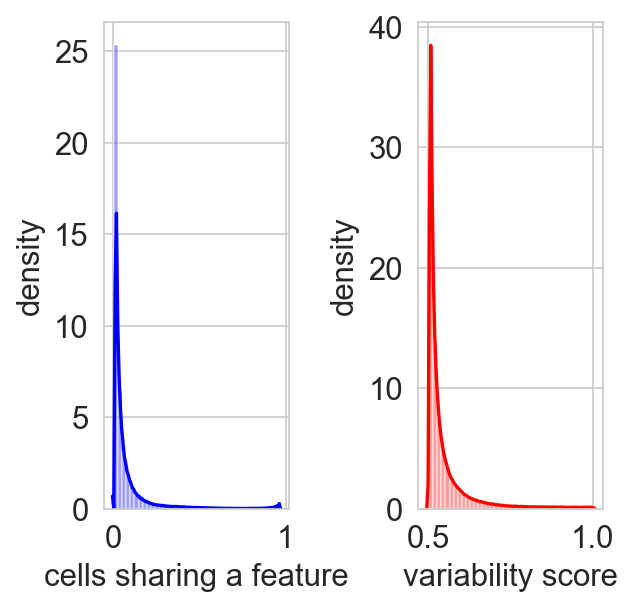

In [19]:
epi.pp.cal_var(adata10x)

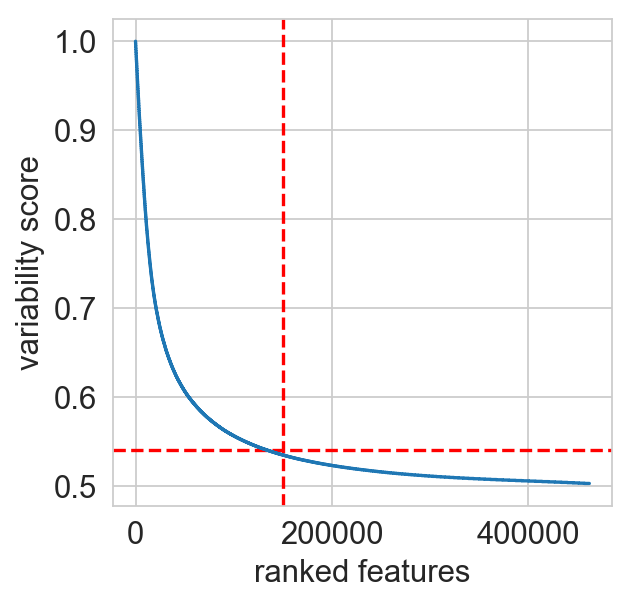

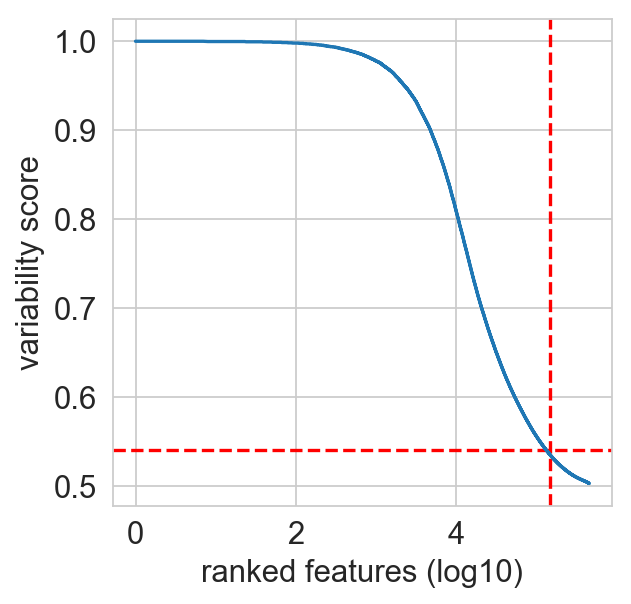

In [20]:
min_score_value = 0.54
nb_feature_selected = 150000
epi.pl.variability_features(adata10x,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected)

epi.pl.variability_features(adata10x,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected)


In [21]:
# save the current matrix in the raw layer
adata10x.raw = adata10x

In [22]:
# create a new AnnData containing only the most variable features
adata10x = epi.pp.select_var_feature(adata10x,
                            nb_features=nb_feature_selected,
                            show=False,
                            copy=True)

In [23]:
adata10x

View of AnnData object with n_obs × n_vars = 3406 × 150410 
    obs: 'nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [24]:
# save intermediary file
result_file = '10x_5kb_windows_top150000_not_normalised.h5ad'
adata10x.write(DATADIR+result_file)

# Load Cusanovich data

In [26]:
adata_Cus = ad.read(DATADIR+"/whole_cusanovich_brain_samples_all_windows.convertedbin.h5ad")
# checking the data matrix is binary - if not, binarize the data matrix
print(np.max(adata_Cus.X))
epi.pp.binarize(adata_Cus)
print(np.max(adata_Cus.X))

# checking the variable names
print(adata_Cus.var_names)

# checking the cell names
print(adata_Cus.obs_names)

30.0
1.0
Index(['chr1_3000000_3005000', 'chr1_3005000_3010000', 'chr1_3010000_3015000',
       'chr1_3015000_3020000', 'chr1_3020000_3025000', 'chr1_3025000_3030000',
       'chr1_3030000_3035000', 'chr1_3035000_3040000', 'chr1_3040000_3045000',
       'chr1_3045000_3050000',
       ...
       'chrY_random_58480000_58485000', 'chrY_random_58490000_58495000',
       'chrY_random_58525000_58530000', 'chrY_random_58530000_58535000',
       'chrY_random_58555000_58560000', 'chrY_random_58595000_58600000',
       'chrY_random_58610000_58615000', 'chrY_random_58615000_58620000',
       'chrY_random_58620000_58625000', 'chrY_random_58655000_58660000'],
      dtype='object', name='index', length=513846)
Index(['AGCGATAGAACGCGCAGAGATGCAGTTCGGCTCTGA-0-0-0',
       'AGCGATAGAACGCGCAGATCAATATCGATATAGCCT-0-0-0',
       'AGCGATAGAATATTACTTCAATGAGTCCGGCTCTGA-0-0-0',
       'AGCGATAGAATATTACTTCCATCGTTCCTATAGCCT-0-0-0',
       'AGCGATAGAGACCATATCGTAGACCTGGTATAGCCT-0-0-0',
       'AGCGATAGAGAGGAGAATCCAT

In [27]:
var_name = []
for n in adata_Cus.var_names.tolist():
    n = n.split('_')
    n[-2] = str(int(n[-2])+1)
    n = "_".join(n)
    var_name.append(n)
    
adata_Cus.var_names = var_name

#### check that the matrix is binary

In [28]:
np.max(adata_Cus.X)

1.0

#### preliminary filtering

In [38]:
# only keep the prefrontal cortex
set(adata_Cus.obs['tissue'])

{'Cerebellum_62216',
 'NA',
 'PreFrontalCortex_62216',
 'WholeBrainA_62216',
 'WholeBrainA_62816'}

In [39]:
adata_Cus = adata_Cus[adata_Cus.obs['tissue']=='PreFrontalCortex_62216',:].copy()
adata_Cus

AnnData object with n_obs × n_vars = 5959 × 503306 
    obs: 'batch', 'cell_type', 'tissue', 'nb_features'
    var: 'keep', 'n_cells', 'commonness'

In [40]:
# remove any potential empty eatures or barcodes
epi.pp.filter_cells(adata_Cus, min_features=1)
epi.pp.filter_features(adata_Cus, min_cells=1)

In [41]:
adata_Cus

AnnData object with n_obs × n_vars = 5959 × 501444 
    obs: 'batch', 'cell_type', 'tissue', 'nb_features'
    var: 'keep', 'n_cells', 'commonness'

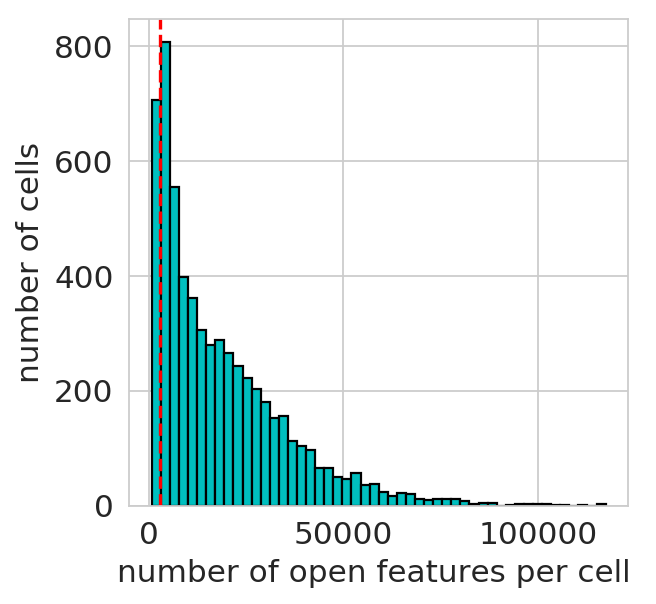

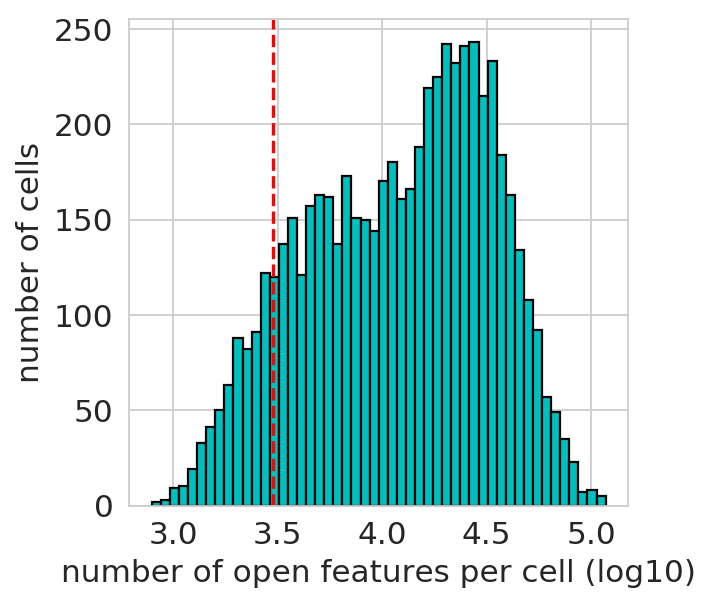

In [42]:
# set a minimum number of cells to keep 
min_features = 3000

epi.pp.coverage_cells(adata_Cus, binary=True, log=False, bins=50,
               threshold=min_features, save='Cusanovich_brain_coverage_cells.png')
epi.pp.coverage_cells(adata_Cus, binary=True, log=10, bins=50,
               threshold=min_features, save='Cusanovich_brain_coverage_cells.png')

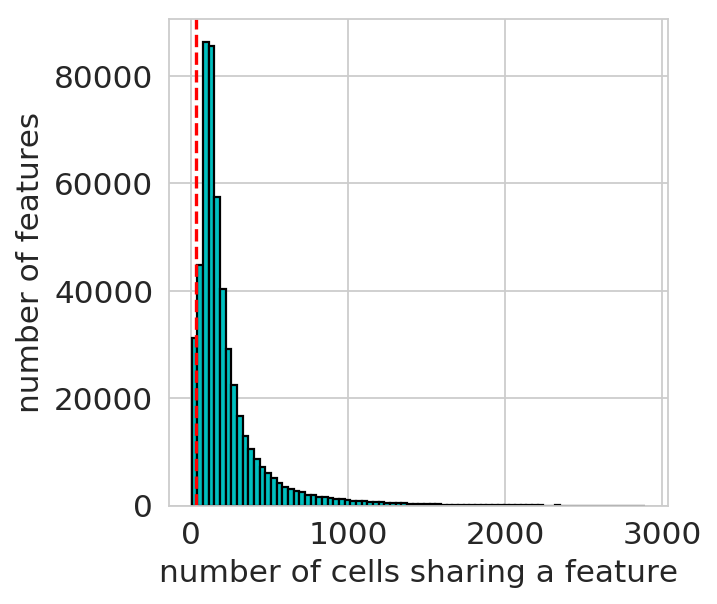

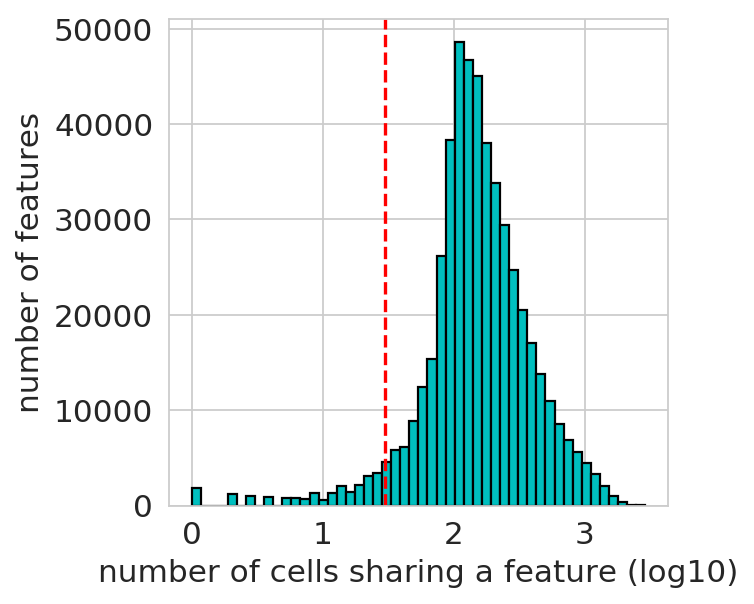

In [43]:
# minimum number of cells sharing a feature
min_cells = 30
epi.pp.coverage_features(adata_Cus, binary=True, log=False, 
                        threshold=min_cells)
epi.pp.coverage_features(adata_Cus, binary=True, log=True, 
                        threshold=min_cells)

### Actually filtering the cells

In [44]:
adata_Cus

AnnData object with n_obs × n_vars = 5959 × 501444 
    obs: 'batch', 'cell_type', 'tissue', 'nb_features'
    var: 'keep', 'n_cells', 'commonness'

In [45]:
min_features = 3000
epi.pp.filter_cells(adata_Cus, min_features=min_features)

In [46]:
adata_Cus

AnnData object with n_obs × n_vars = 5299 × 501444 
    obs: 'batch', 'cell_type', 'tissue', 'nb_features'
    var: 'keep', 'n_cells', 'commonness'

In [47]:
min_cells = 30
epi.pp.filter_features(adata_Cus, min_cells=min_cells)

In [48]:
adata_Cus

AnnData object with n_obs × n_vars = 5299 × 477230 
    obs: 'batch', 'cell_type', 'tissue', 'nb_features'
    var: 'keep', 'n_cells', 'commonness'

#### Looking at the QC plots after filtering

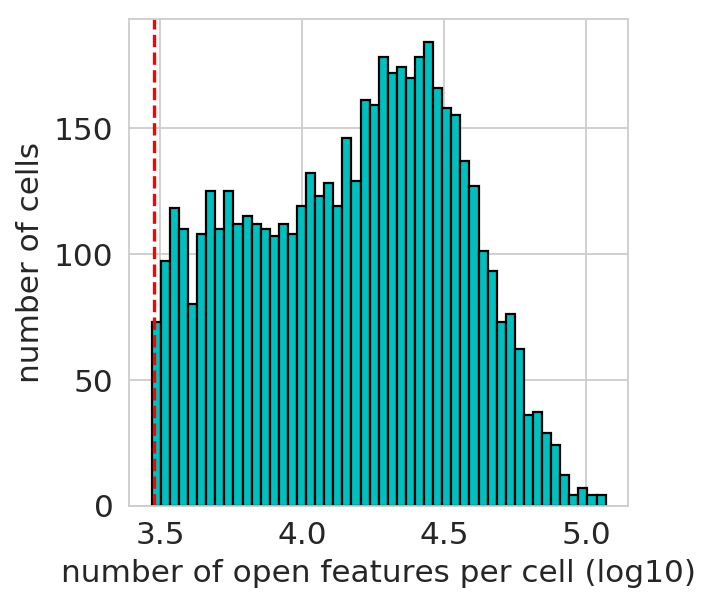

In [49]:
epi.pp.coverage_cells(adata_Cus, binary=True, log='log10', bins=50, threshold=min_features)

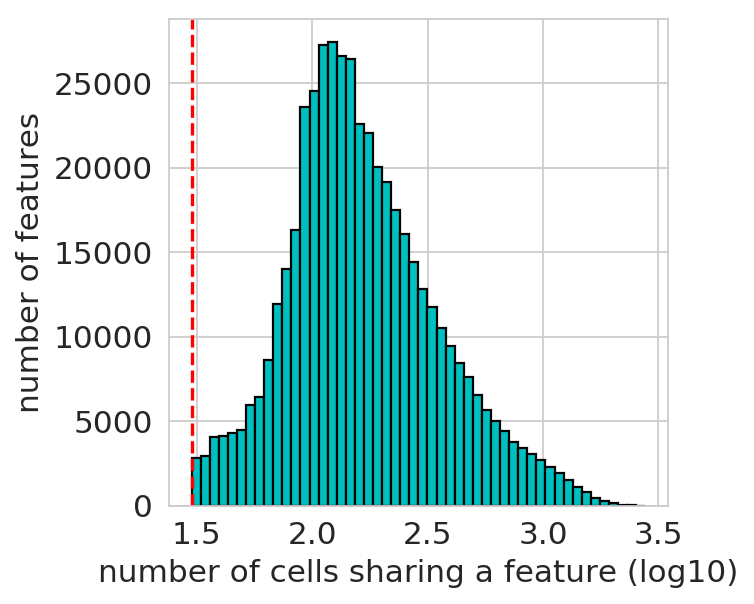

In [50]:
epi.pp.coverage_features(adata_Cus, binary=True, log='log10', bins=50, threshold=min_cells)

### Identifying the most variable features

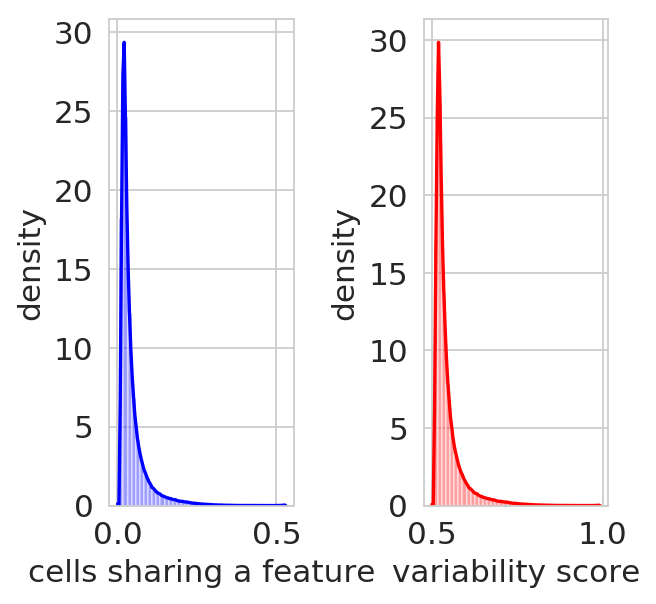

In [51]:
epi.pp.cal_var(adata_Cus)

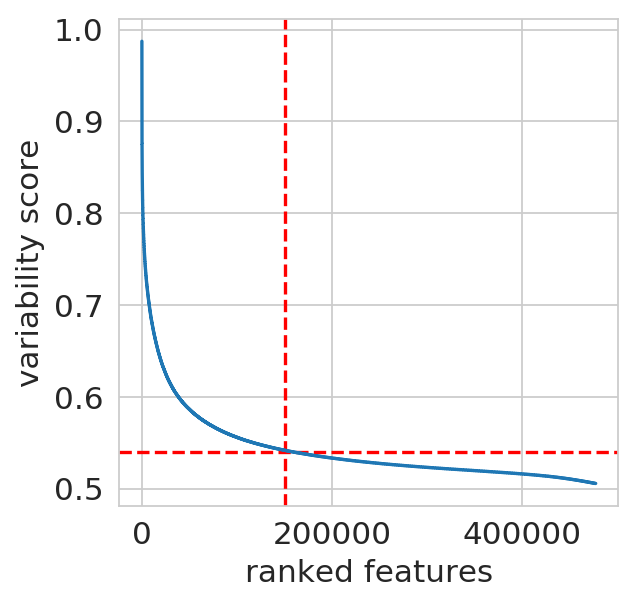

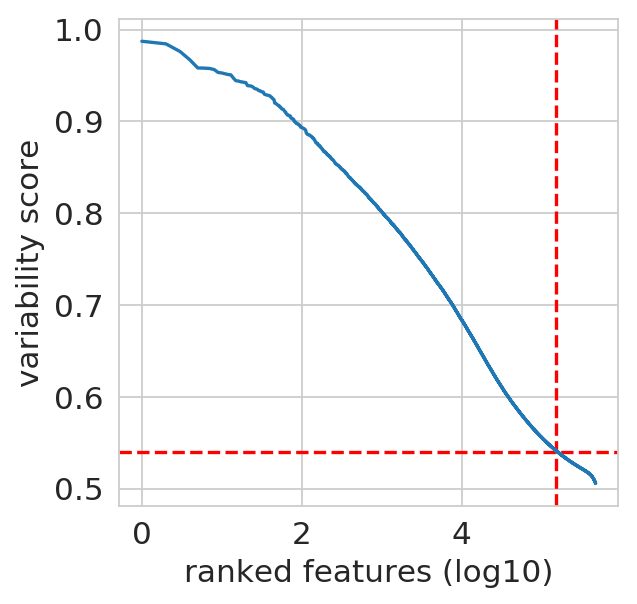

In [52]:
min_score_value = 0.54
nb_feature_selected = 150000
epi.pl.variability_features(adata_Cus,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix.png')

epi.pl.variability_features(adata_Cus,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix_log10.png')


In [53]:
# save the current matrix in the raw layer
adata_Cus.raw = adata_Cus

In [54]:
# create a new AnnData containing only the most variable features
adata_Cus = epi.pp.select_var_feature(adata_Cus,
                            nb_features=nb_feature_selected,
                            show=False,
                            copy=True)

In [55]:
adata_Cus

View of AnnData object with n_obs × n_vars = 5299 × 150859 
    obs: 'batch', 'cell_type', 'tissue', 'nb_features'
    var: 'keep', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [56]:
# save intermediary file
result_file = 'Cus_prefrontal_cortex_brain_5kb_windows_top150000_not_normalised.h5ad'
adata_Cus.write(DATADIR+result_file)

# Load Fang data

In [27]:
adata_merge_Fang=ad.read('Fang_all_samples_merged.h5ad')
adata_merge_Fang

AnnData object with n_obs × n_vars = 85821 × 545118 
    obs: 'batch', 'batchname', 'n_genes'

In [28]:
contingency_table_prefilt = pd.crosstab(adata_merge_Fang.obs['batchname'],
                                adata_merge_Fang.obs['batchname'],
                                margins = True)
contingency_table_prefilt

batchname,CEMBA180226_1A,CEMBA180227_1A,CEMBA180305_2B,CEMBA180306_2B,CEMBA180308_3B,CEMBA180312_3B,All
batchname,,,,,,,
CEMBA180226_1A,14269,0,0,0,0,0,14269
CEMBA180227_1A,0,13527,0,0,0,0,13527
CEMBA180305_2B,0,0,14545,0,0,0,14545
CEMBA180306_2B,0,0,0,14757,0,0,14757
CEMBA180308_3B,0,0,0,0,14585,0,14585
CEMBA180312_3B,0,0,0,0,0,14138,14138
All,14269,13527,14545,14757,14585,14138,85821


In [29]:
adata_merge_Fang.obs['batchname_Fang'] = adata_merge_Fang.obs['batchname'].copy()
adata_merge_Fang

AnnData object with n_obs × n_vars = 85821 × 545118 
    obs: 'batch', 'batchname', 'n_genes', 'batchname_Fang'

In [30]:
# check if the matrix is binary
print(np.max(adata_merge_Fang.X))

1.0


### preliminary filtering

We only want to keep 

In [31]:
adata_merge_Fang = adata_merge_Fang[adata_merge_Fang.obs['batchname_Fang']=='CEMBA180305_2B',:].copy()                                                                                                                                                                                                                                                                                                        chname_Fang']=='CEMBA180305_2B',:].copy()

In [32]:
adata_merge_Fang

AnnData object with n_obs × n_vars = 14545 × 545118 
    obs: 'batch', 'batchname', 'n_genes', 'batchname_Fang'

In [33]:
# remove any potential empty eatures or barcodes
epi.pp.filter_cells(adata_merge_Fang, min_features=1)
epi.pp.filter_features(adata_merge_Fang, min_cells=1)

In [34]:
adata_merge_Fang

AnnData object with n_obs × n_vars = 14545 × 502290 
    obs: 'batch', 'batchname', 'batchname_Fang', 'nb_features'
    var: 'n_cells'

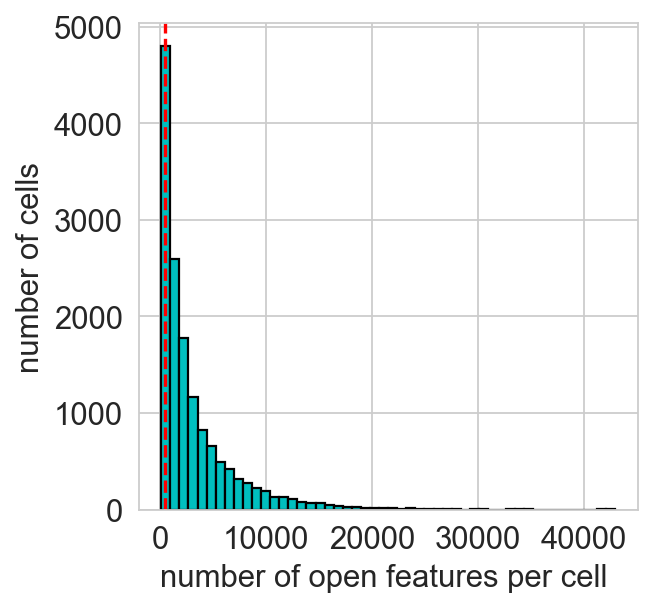

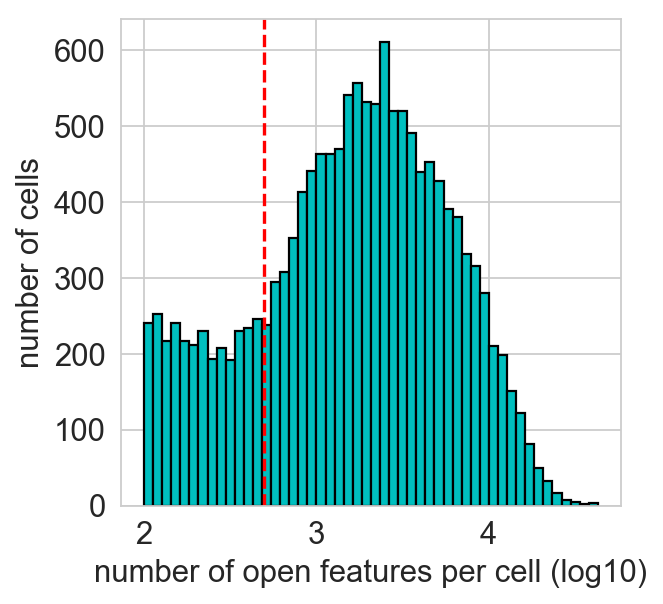

In [35]:
# set a minimum number of cells to keep 
min_features = 500

epi.pp.coverage_cells(adata_merge_Fang, binary=True, log=False, bins=50,
               threshold=min_features, save='Fang_coverage_cells.png')
epi.pp.coverage_cells(adata_merge_Fang, binary=True, log=10, bins=50,
               threshold=min_features, save='Fang_coverage_cells.png')

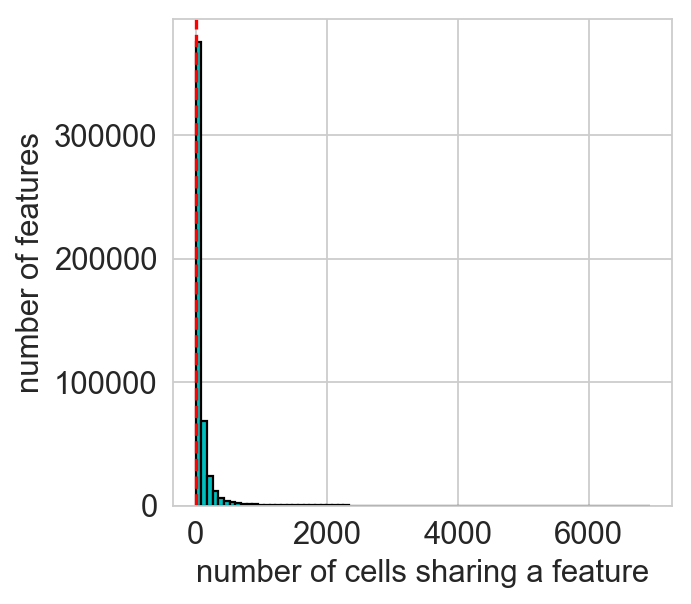

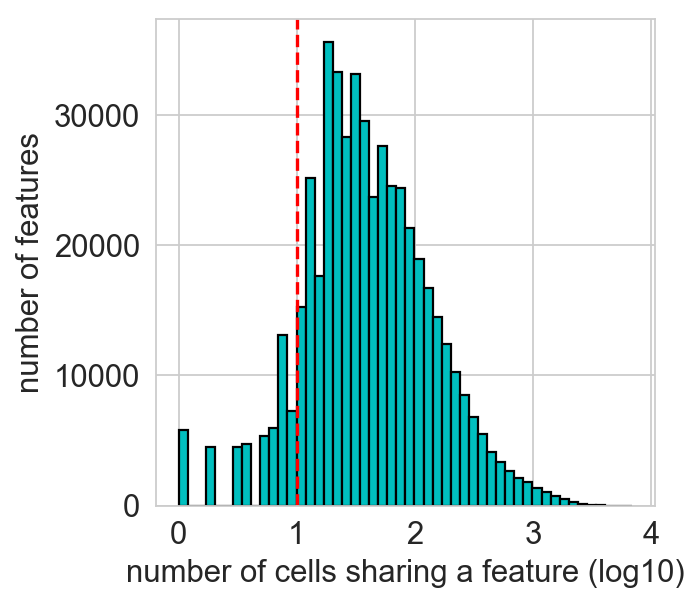

In [36]:
# minimum number of cells sharing a feature
min_cells = 10
epi.pp.coverage_features(adata_merge_Fang, binary=True, log=False, 
                        threshold=min_cells)
epi.pp.coverage_features(adata_merge_Fang, binary=True, log=True, 
                        threshold=min_cells)

### Actually filtering the cells

In [37]:
adata_merge_Fang

AnnData object with n_obs × n_vars = 14545 × 502290 
    obs: 'batch', 'batchname', 'batchname_Fang', 'nb_features'
    var: 'n_cells', 'commonness'

In [38]:
min_features = 500
epi.pp.filter_cells(adata_merge_Fang, min_features=min_features)

In [39]:
adata_merge_Fang

AnnData object with n_obs × n_vars = 11587 × 502290 
    obs: 'batch', 'batchname', 'batchname_Fang', 'nb_features'
    var: 'n_cells', 'commonness'

In [40]:
min_cells = 10
epi.pp.filter_features(adata_merge_Fang, min_cells=min_cells)

In [41]:
adata_merge_Fang

AnnData object with n_obs × n_vars = 11587 × 449429 
    obs: 'batch', 'batchname', 'batchname_Fang', 'nb_features'
    var: 'n_cells', 'commonness'

#### Looking at the QC plots after filtering

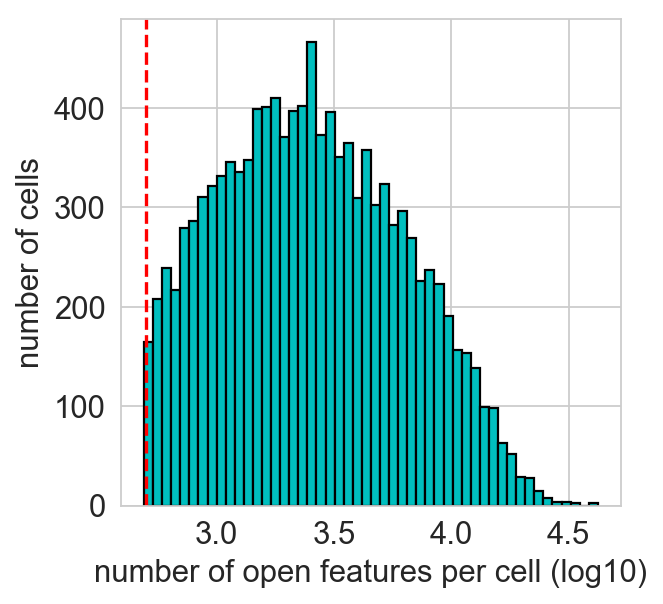

In [42]:
epi.pp.coverage_cells(adata_merge_Fang, binary=True, log='log10', bins=50, threshold=min_features)

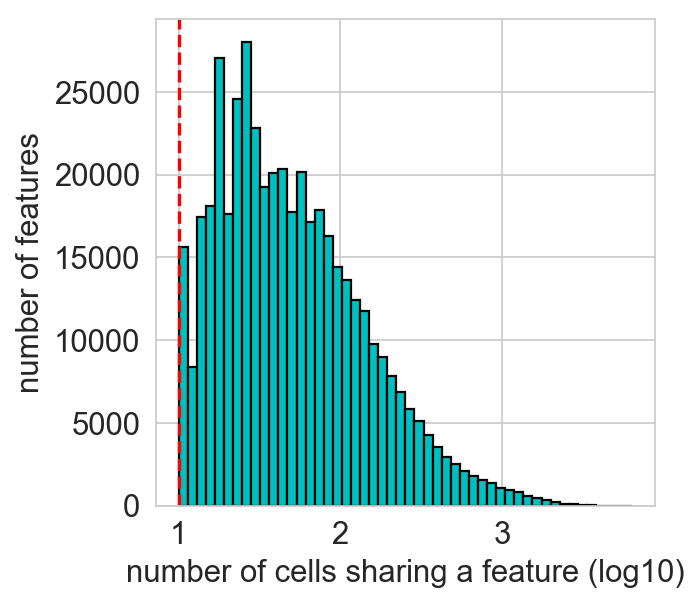

In [43]:
epi.pp.coverage_features(adata_merge_Fang, binary=True, log='log10', bins=50, threshold=min_cells)

### Identifying the most variable features

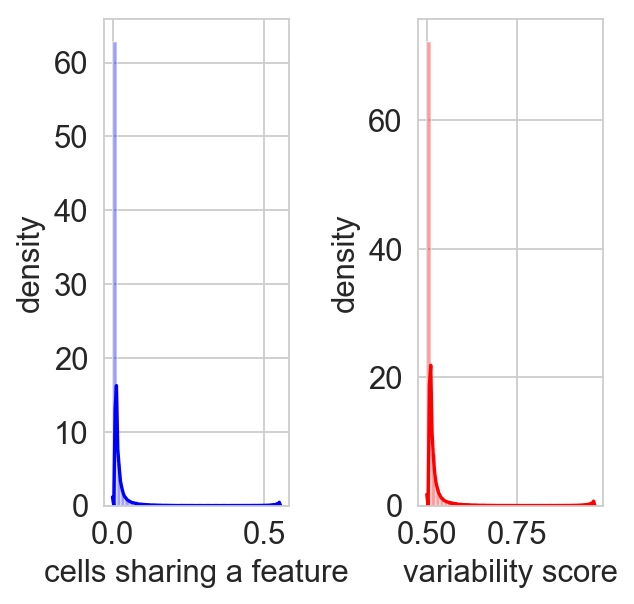

In [44]:
epi.pp.cal_var(adata_merge_Fang)

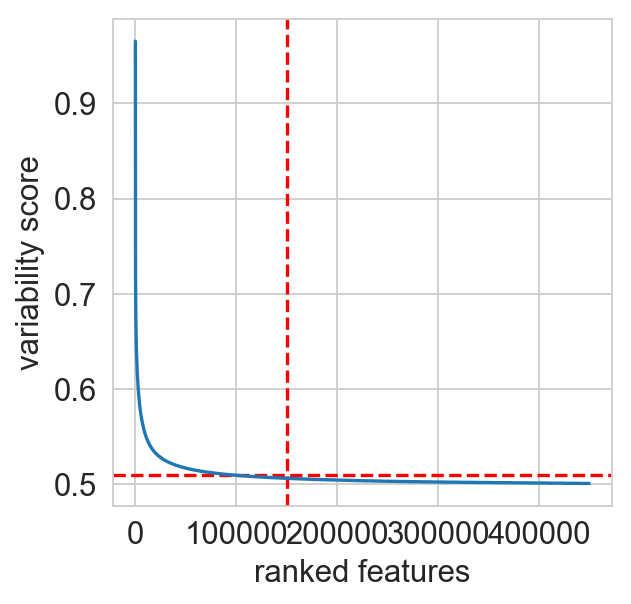

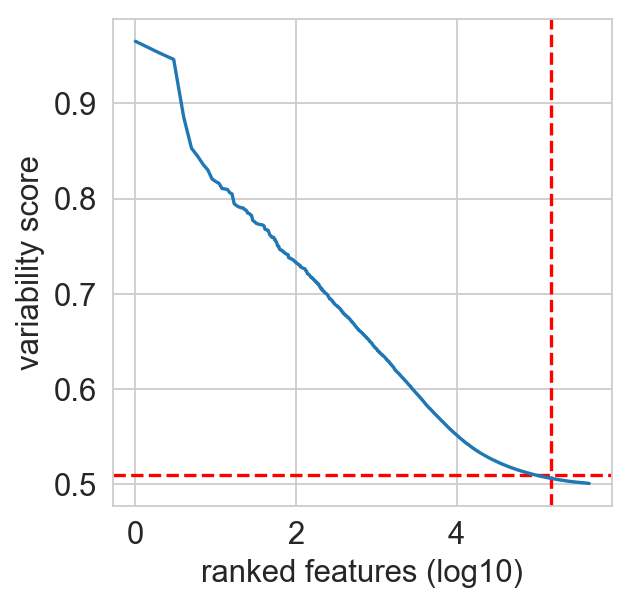

In [45]:
min_score_value = 0.51
nb_feature_selected = 150000
epi.pl.variability_features(adata_merge_Fang,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected)

epi.pl.variability_features(adata_merge_Fang,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected)



In [46]:
# save the current matrix in the raw layer
adata_merge_Fang.raw = adata_merge_Fang

In [47]:
# create a new AnnData containing only the most variable features
adata_merge_Fang = epi.pp.select_var_feature(adata_merge_Fang,
                            nb_features=nb_feature_selected,
                            show=False,
                            copy=True)

In [48]:
adata_merge_Fang

View of AnnData object with n_obs × n_vars = 11587 × 151484 
    obs: 'batch', 'batchname', 'batchname_Fang', 'nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [49]:
#adata_merge_Fang.write(DATADIR+'Fang_5kb_CEMBA180305_2B_windows_top150000_not_normalised.h5ad')

# Merge the 3 datasets (not normalised)

### merge 10x Genomics and Fang et al. 2019

In [86]:
adata10x = ad.read(DATADIR+'10x_5kb_windows_top150000_not_normalised.h5ad')

In [87]:
adata_merge_Fang = ad.read(DATADIR+'Fang_5kb_CEMBA180305_2B_windows_top150000_not_normalised.h5ad')

In [88]:
# Merge 10x and Fang
adata_merged = adata10x.concatenate(adata_merge_Fang)
adata_merged

AnnData object with n_obs × n_vars = 14993 × 128104 
    obs: 'batch', 'batchname', 'batchname_Fang', 'cell_type_label_transfer', 'nb_features'
    var: 'n_cells-0', 'commonness-0', 'prop_shared_cells-0', 'variability_score-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'

In [89]:
del adata10x, adata_merge_Fang

In [90]:
batchname=copy.copy(adata_merged.obs['batch'])
batchname

batchname = batchname.map({ '1' : 'Fang et al. 2019', '0' : '10x Genomics' })
batchname

adata_merged.obs['batchname'] = batchname
adata_merged

AnnData object with n_obs × n_vars = 14993 × 128104 
    obs: 'batch', 'batchname', 'batchname_Fang', 'cell_type_label_transfer', 'nb_features'
    var: 'n_cells-0', 'commonness-0', 'prop_shared_cells-0', 'variability_score-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'

In [91]:
contingency_table_prefilt = pd.crosstab(adata_merged.obs['batchname'],
                                adata_merged.obs['batchname'],
                                margins = True)
contingency_table_prefilt

batchname,10x Genomics,Fang et al. 2019,All
batchname,,,
10x Genomics,3406,0,3406
Fang et al. 2019,0,11587,11587
All,3406,11587,14993


In [92]:
adata_merged.write(DATADIR+'10x_Fang_CEMBA180305_150000_not_normalised.h5ad')

... storing 'batchname' as categorical
... storing 'batchname_Fang' as categorical
... storing 'cell_type_label_transfer' as categorical


In [95]:
adata_merged

AnnData object with n_obs × n_vars = 14993 × 128104 
    obs: 'batch', 'batchname', 'batchname_Fang', 'cell_type_label_transfer', 'nb_features'
    var: 'n_cells-0', 'commonness-0', 'prop_shared_cells-0', 'variability_score-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    uns: 'pca', 'neighbors', 'cell_type_label_transfer_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

### add Cusanovich data

In [98]:
adata_Cus = ad.read(DATADIR+'Cus_prefrontal_cortex_brain_5kb_windows_top150000_not_normalised.h5ad')
#adata_Cus = ad.read(DATADIR+'Cus_brain_5kb_windows_top150000_not_normalised.h5ad')

adata_Cus

AnnData object with n_obs × n_vars = 14824 × 150409 
    obs: 'batch', 'cell_type', 'tissue', 'nb_features'
    var: 'keep', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [99]:
adata_merged = adata_merged.concatenate(adata_Cus)

In [100]:
adata_merged

AnnData object with n_obs × n_vars = 29817 × 57070 
    obs: 'batch', 'batchname', 'batchname_Fang', 'cell_type', 'cell_type_label_transfer', 'nb_features', 'tissue'
    var: 'n_cells-0-0', 'commonness-0-0', 'prop_shared_cells-0-0', 'variability_score-0-0', 'n_cells-1-0', 'commonness-1-0', 'prop_shared_cells-1-0', 'variability_score-1-0', 'keep-1', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'

In [101]:
contingency_table_prefilt = pd.crosstab(adata_merged.obs['batchname'],
                                adata_merged.obs['batchname'],
                                margins = True)
contingency_table_prefilt

batchname,10x Genomics,Fang et al. 2019,All
batchname,,,
10x Genomics,3406,0,3406
Fang et al. 2019,0,11587,11587
All,3406,11587,14993


In [102]:
contingency_table_prefilt = pd.crosstab(adata_merged.obs['batch'],
                                adata_merged.obs['batch'],
                                margins = True)
contingency_table_prefilt

batch,0,1,All
batch,,,
0,14993,0,14993
1,0,14824,14824
All,14993,14824,29817


In [4]:
adata_merged.obs['batchname'] = adata_merged.obs['batchname'].replace(np.nan, 'GSE111586', regex=False)

In [104]:
del adata_Cus

In [105]:
contingency_table_prefilt = pd.crosstab(adata_merged.obs['batchname'],
                                adata_merged.obs['batchname'],
                                margins = True)
contingency_table_prefilt

batchname,10x Genomics,Fang et al. 2019,GSE111586,All
batchname,,,,
10x Genomics,3406,0,0,3406
Fang et al. 2019,0,11587,0,11587
GSE111586,0,0,14824,14824
All,3406,11587,14824,29817


In [106]:
adata_merged

AnnData object with n_obs × n_vars = 29817 × 57070 
    obs: 'batch', 'batchname', 'batchname_Fang', 'cell_type', 'cell_type_label_transfer', 'nb_features', 'tissue'
    var: 'n_cells-0-0', 'commonness-0-0', 'prop_shared_cells-0-0', 'variability_score-0-0', 'n_cells-1-0', 'commonness-1-0', 'prop_shared_cells-1-0', 'variability_score-1-0', 'keep-1', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'

In [107]:
adata_merged.write(DATADIR+'small_dataset_10x_Fang_Cus_150000_not_normalised.h5ad')

... storing 'batchname' as categorical
... storing 'batchname_Fang' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_label_transfer' as categorical
... storing 'tissue' as categorical
... storing 'keep-1' as categorical


# Filtering

Filter cells that do not contain enough covered windows (once teh 3 datasets are merged)

In [26]:
adata = ad.read(DATADIR+'small_dataset_10x_Fang_Cus_150000_not_normalised.h5ad')

adata

In [ ]:
# set a minimum number of cells to keep 
min_features = 500

epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=min_features, save='Cus_Fang_10x_brain_coverage_cells.png')
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=min_features, save='Cus_Fang_10x_brain_coverage_cells.png')

In [5]:
epi.pp.filter_cells(adata, min_features=500)

### Add the count layer

In [ ]:
adata.layers['counts'] = adata.X

### Normalisation

In [31]:
# library size normalisation of all 3 datasts at the same time
epi.pp.normalize_per_cell(adata)
epi.pp.log1p(adata)

In [33]:
epi.pp.lazy(adata)

/Users/anna.danese/anaconda3/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


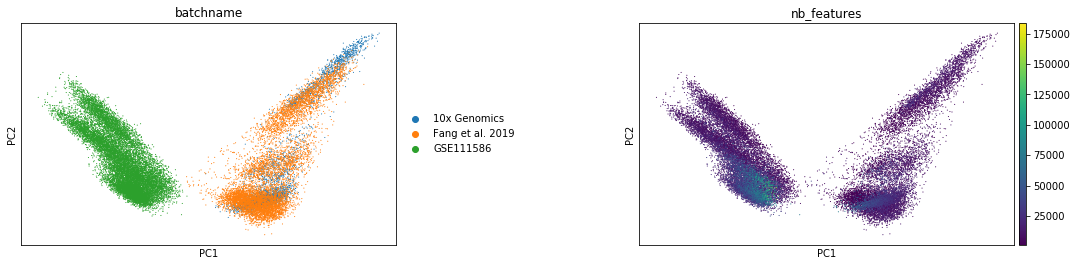

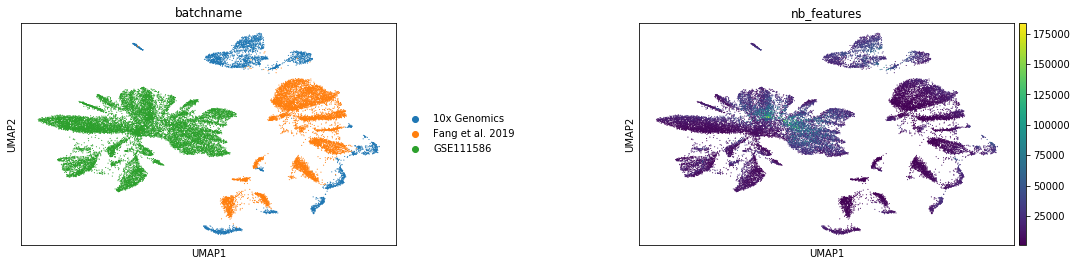

In [34]:
fplot="_brain_atac_3datasets_prefilter_top_var_feat.pdf"
sc.pl.pca(adata, wspace=0.5, color=['batchname','nb_features'], save=fplot)
sc.pl.umap(adata, wspace=0.5, color=['batchname','nb_features'], save=fplot)

In [35]:
adata

AnnData object with n_obs × n_vars = 25960 × 57070 
    obs: 'batch', 'batchname', 'batchname_Fang', 'cell_type', 'cell_type_label_transfer', 'nb_features', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells-0-0', 'commonness-0-0', 'prop_shared_cells-0-0', 'variability_score-0-0', 'n_cells-1-0', 'commonness-1-0', 'prop_shared_cells-1-0', 'variability_score-1-0', 'keep-1', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'batchname_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [36]:
adata.write(DATADIR+'small_dataset_10x_Fang_Cus_150000_normalised_cell_label_counts.h5ad')

### Check batchs and cell labels

In [8]:
adata =ad.read(DATADIR+'small_dataset_10x_Fang_Cus_150000_normalised_cell_label_counts.h5ad')
adata

AnnData object with n_obs × n_vars = 25960 × 57070 
    obs: 'batch', 'batchname', 'batchname_Fang', 'cell_type', 'cell_type_label_transfer', 'nb_features', 'tissue', 'n_genes', 'n_counts', 'final_cell_label'
    var: 'n_cells-0-0', 'commonness-0-0', 'prop_shared_cells-0-0', 'variability_score-0-0', 'n_cells-1-0', 'commonness-1-0', 'prop_shared_cells-1-0', 'variability_score-1-0', 'keep-1', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

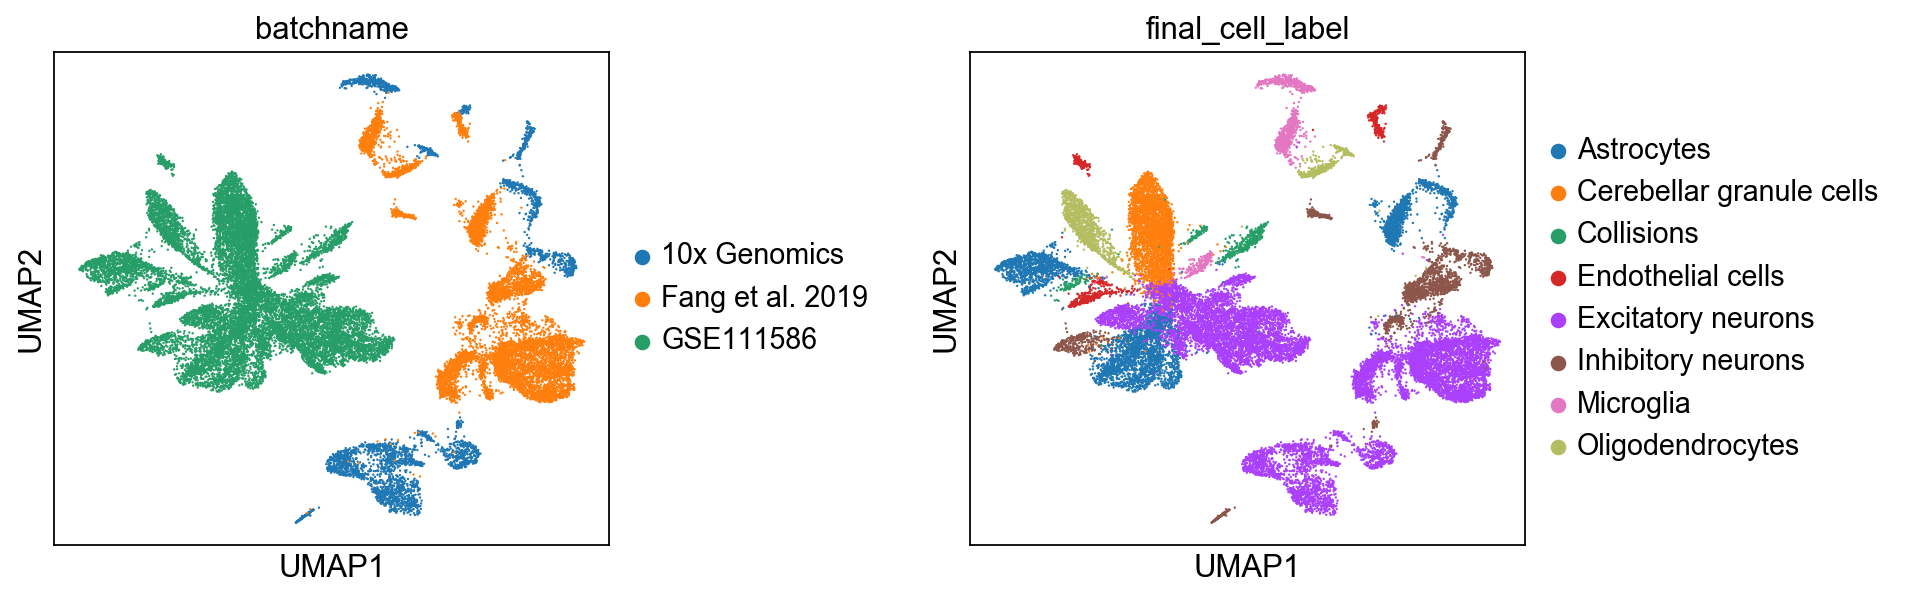

In [12]:
sc.pl.umap(adata, color=['batchname', 'final_cell_label'], wspace=0.5)